In [1]:
#!pip3 install -e ../qick/

In [3]:
import sys
import Pyro4
from qick import QickConfig
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

print("blob0")

ns_host = "192.168.2.99"
ns_port = 8888
proxy_name = "myqick"

ns = Pyro4.locateNS(host=ns_host, port=ns_port)
print("blob2")
# print the nameserver entries: you should see the QickSoc proxy
for k,v in ns.list().items():
    print(k,v)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

from qick import *
%pylab inline

blob0


NamingError: Failed to locate the nameserver

In [8]:
class LoopbackProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]

        # set the nyquist zone
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        # configure the readout lengths and downconversion frequencies (ensuring it is an available DAC frequency)
        for ch in cfg["ro_chs"]:
            self.declare_readout(ch=ch, length=self.cfg["readout_length"],
                                 freq=self.cfg["pulse_freq"], gen_ch=cfg["res_ch"])

        # convert frequency to DAC frequency (ensuring it is an available ADC frequency)
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])
        phase = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        gain = cfg["pulse_gain"]
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase, gain=gain)

        style=self.cfg["pulse_style"]

        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            self.add_gauss(ch=res_ch, name="measure", sigma=sigma, length=sigma*5)
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, length=cfg["length"])
        elif style == "flat_top":
            # The first half of the waveform ramps up the pulse, the second half ramps down the pulse
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        # fire the pulse
        # trigger all declared ADCs
        # pulse PMOD0_0 for a scope trigger
        # pause the tProc until readout is done
        # increment the time counter to give some time before the next measurement
        # (the syncdelay also lets the tProc get back ahead of the clock)
        self.measure(pulse_ch=self.cfg["res_ch"], 
                     adcs=self.ro_chs,
                     pins=[0], 
                     adc_trig_offset=self.cfg["adc_trig_offset"],
                     wait=True,
                     syncdelay=self.us2cycles(self.cfg["relax_delay"]))
        print("in body")
        # equivalent to the following:
#         self.trigger(adcs=self.ro_chs,
#                      pins=[0], 
#                      adc_trig_offset=self.cfg["adc_trig_offset"])
#         self.pulse(ch=self.cfg["res_ch"])
#         self.wait_all()
#         self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

config={"res_ch":6, # --Fixed
        "ro_chs":[0], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        
        "length":30, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":100, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":3000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":100
        # Try varying soft_avgs from 1 to 200 averages

       }

prog =LoopbackProgram(soccfg, config)
#print(prog)
iq_list = prog.acquire_decimated(soc, progress=True)

in body


  0%|          | 0/100 [00:00<?, ?it/s]

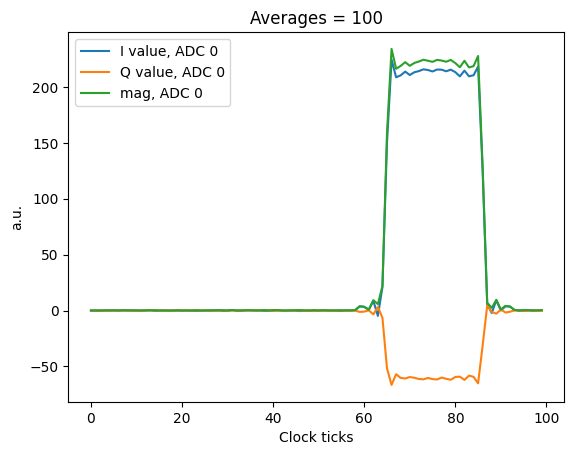

In [9]:
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();

In [2]:
class LongPulseProgram(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        self.declare_readout(ch=cfg["ro_chs"], length=cfg["readout_length"], freq=cfg["pulse_freq"], gen_ch=cfg["res_ch"])
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"])
        phase0 = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase0, style=cfg["pulse_style"])

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))
        self.synci(0)
        
        self.set_pulse_registers(ch=self.cfg["res_ch"], length=self.cfg["length"], 
                                     gain=int(self.cfg["pulse_gain"]/2 + (1/50)*0*self.cfg["pulse_gain"]/2), phrst=1)
        self.trigger(adcs=self.ro_chs, pins=[0], adc_trig_offset=int(self.cfg["adc_trig_offset"] 
                                        + (self.cfg["length"]-self.cfg["readout_length"])/2))
        self.pulse(ch=self.cfg["res_ch"], t=0)
        for i in range(1, self.cfg["nb_pulses"]):
            self.set_pulse_registers(ch=self.cfg["res_ch"], length=self.cfg["length"],
                                     gain=int(self.cfg["pulse_gain"]/2 + (1/50)*i*self.cfg["pulse_gain"]/2))
            self.trigger(adcs=self.ro_chs, pins=[0], adc_trig_offset=int(self.cfg["adc_trig_offset"] 
                                         + i*self.cfg["length"] + (self.cfg["length"]-self.cfg["readout_length"])/2))
            self.pulse(ch=self.cfg["res_ch"], t=i*self.cfg["length"])
        
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

config={"res_ch":6, # --Fixed
        "ro_chs":0, # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1000.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        "length":4000, # [Clock ticks]        
        "readout_length":100, # [Clock ticks]
        "pulse_gain":30000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 100, # [Clock ticks]
        "nb_pulses": 200,
        "soft_avgs":1
       }
fs = 1e6*soccfg['readouts'][config['ro_chs']]['fs']/8 # en Hz
ts = 1/fs  # en s
x = 1e6*ts*config['readout_length']
print("readout duration: ", x, " us")
fs = 1e6*soccfg['gens'][config['res_ch']]['f_fabric'] # en Hz
ts = 1/fs  # en s
x = 1e6*ts*config['length']
print("pulse duration: ", config['nb_pulses']*x, " us")

readout duration:  0.32552083333333337  us
pulse duration:  1860.1190476190475  us


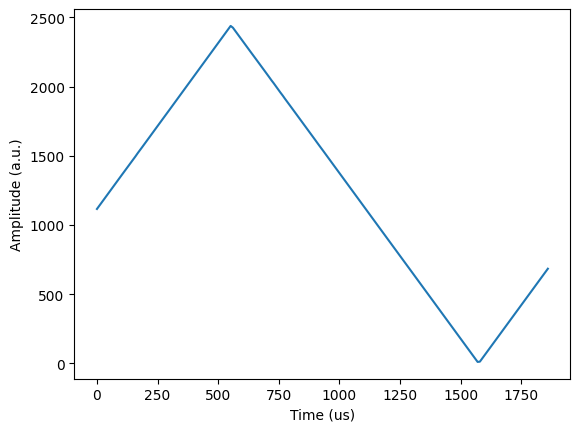

[1115.8533884  1138.37775145 1161.12392108 1183.37211265 1205.46173083
 1227.86625795 1250.14605647 1272.6412381  1295.04560823 1317.83287321
 1339.93649738 1362.63017173 1384.76954617 1407.41996849 1429.54785754
 1451.53333114 1473.74015417 1496.10575649 1519.54761222 1541.30357691
 1563.73638303 1586.26760684 1608.58226635 1630.26027983 1653.20653171
 1675.9830091  1697.93728394 1720.48907829 1743.28390367 1765.61389825
 1787.63542897 1809.89643695 1832.63773193 1855.10063094 1876.78118091
 1899.86279526 1922.4329606  1944.92262314 1967.11018797 1989.35859575
 2011.9396476  2034.53076558 2056.26279947 2079.16508197 2101.49224612
 2123.78443456 2147.63246784 2168.97510825 2191.06673203 2213.73727224
 2235.91468858 2259.18451681 2281.26707704 2303.80227721 2326.20446677
 2348.83180705 2371.17625825 2393.08182062 2415.91973445 2439.08100392
 2426.37821623 2403.92287206 2381.68416399 2359.63811439 2336.84972339
 2314.5979733  2291.90200107 2270.2962081  2247.38507846 2225.714494
 2203.09

In [11]:
prog =LongPulseProgram(soccfg, config)
avgi, avgq = prog.acquire(soc)
fs = 1e6*soccfg['gens'][config['res_ch']]['f_fabric'] # en Hz
ts = 1/fs  # en s
x = 1e6*ts*config['length']
t = np.linspace(0, len(avgi[0])*x, len(avgi[0]))
plt.figure()
mag = np.abs(avgi[0] + 1j*avgq[0])
plt.plot(t, mag, label="mag")
plt.ylabel("Amplitude (a.u.)")
plt.xlabel("Time (us)")
plt.show()
print(np.abs(avgi[0] + 1j*avgq[0]))
print(avgi[0])
print(len(avgi[0]))

In [10]:
prog =LongPulseProgram(soccfg, config)
#print(prog)
iq_list = 0
iq_list = prog.acquire_decimated(soc, progress=True)
#print(iq_list[0][18][1])

plt.figure(1)
for i in range(0, len(iq_list[0])):
    #plt.plot(iq_list[0][i][0], label="I")
    #plt.plot(iq_list[0][i][1], label="Q")
    mag = np.abs(iq_list[0][i][0]+1j*iq_list[0][i][1])
    plt.plot(mag, label="mag")
    print(np.mean(mag))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
#plt.title("Averages = " + str(config["soft_avgs"]))
#plt.legend();

RuntimeError: Warning: requested readout length (10 x 200 trigs x 1 reps) exceeds buffer size (1024)

readout duration:  3.2552083333333335  us
pulse duration:  0.13950892857142858  us


  0%|          | 0/1 [00:00<?, ?it/s]


// Program

        regwi 3, $22, 62415240;                 //freq = 62415240
        regwi 3, $23, 0;                        //phase = 0
        regwi 3, $25, 30000;                    //gain = 30000
        regwi 3, $26, 589884;                   //phrst| stdysel | mode | | outsel = 0b01001 | length = 60 
        synci 200;
        regwi 0, $15, 0;
        regwi 0, $14, 0;
LOOP_J: waiti 0, 0;
        synci 4301;
        regwi 0, $16, 16385;                    //out = 0b0100000000000001
        seti 0, 0, $16, 0;                      //ch =0 out = $16 @t = 0
        seti 0, 0, $0, 10;                      //ch =0 out = 0 @t = 0
        regwi 3, $25, 30000;                    //gain = 30000
        regwi 3, $26, 1638460;                  //phrst| stdysel | mode | | outsel = 0b11001 | length = 60 
        regwi 3, $27, 0;                        //t = 0
        set 7, 3, $22, $23, $0, $25, $26, $27;  //ch = 6, pulse @t = $27
        waiti 0, 1400;
        synci 5701;
        mathi 0, $1

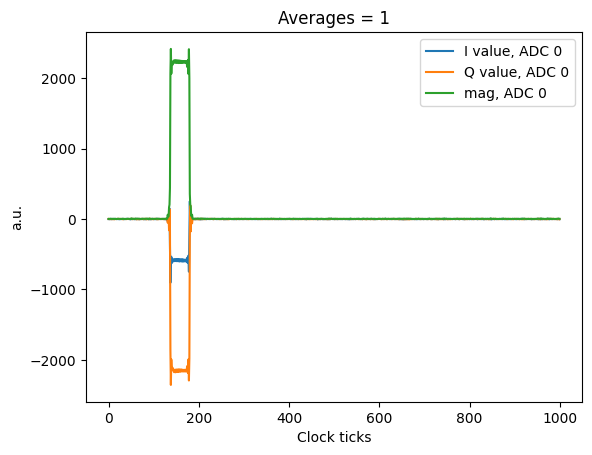

In [7]:
# time of flight

class tof_measure(AveragerProgram):
    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]
        self.declare_gen(ch=cfg["res_ch"], nqz=1)
        
        self.declare_readout(ch=cfg["ro_chs"], length=cfg["readout_length"], freq=cfg["pulse_freq"], gen_ch=cfg["res_ch"])
        freq = self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"])
        phase0 = self.deg2reg(cfg["res_phase"], gen_ch=res_ch)
        self.default_pulse_registers(ch=res_ch, freq=freq, phase=phase0, style=cfg["pulse_style"])
        self.set_pulse_registers(ch=res_ch, length=cfg["length"], gain=cfg["pulse_gain"])

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))
        self.trigger(adcs=self.ro_chs, pins=[0], adc_trig_offset=self.cfg["adc_trig_offset"])
        self.set_pulse_registers(ch=self.cfg["res_ch"], length=self.cfg["length"], gain=self.cfg["pulse_gain"], phrst=1)
        self.pulse(ch=self.cfg["res_ch"], t=0)
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

config={"res_ch":6, # --Fixed
        "ro_chs":0, # --Fixed
        "reps":1, # --Fixed
        "relax_delay":10.0, # --us
        "res_phase":0, # --degrees
        "pulse_style": "const", # --Fixed
        "length":60, # [Clock ticks]        
        "readout_length":1000, # [Clock ticks]
        "pulse_gain":30000, # [DAC units]
        "pulse_freq": 100, # [MHz]
        "adc_trig_offset": 0, # [Clock ticks]
        "soft_avgs":1
       }

fs = 1e6*soccfg['readouts'][config['ro_chs']]['fs']/8 # en Hz
ts = 1/fs  # en s
x = 1e6*ts*config['readout_length']
print("readout duration: ", x, " us")
fs = 1e6*soccfg['gens'][config['res_ch']]['f_fabric'] # en Hz
ts = 1/fs  # en s
x = 1e6*ts*config['length']
print("pulse duration: ", x, " us")


prog =tof_measure(soccfg, config)
iq_list = prog.acquire_decimated(soc, progress=True)
print(prog)
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs']))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs']))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs']))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend();